## Computing Fundamental Matrix in an optimized way
Given two images of the same scene they are related by the epipolar geometry, which algebraic representation is the Fundamental matrix $F $. For any pair of matching points $\boldsymbol{\vec{x}}$ and $\boldsymbol{\vec{x}'}$ the fundamental matrix is defined by the following equation:
$$
\begin{aligned}
    \boldsymbol{\vec{x}}F\boldsymbol{\vec{x}'} = 0
\end{aligned}
$$

Given sufficiently many point matches (at least 7), this equation can be used to compute the unknown matrix F. There are several ways to solve this problem, some of them listed below:
- Normalized 8-point algorithm
- Algebraic minimization algorithm
- Geometric minimization algorithm

Here, we'll implement the third one using Python adn OpenCV, but first we should comment the other two, so we can see the benefits of the chosen one.

### Normalized 8-point algorithm

From the equation

$$
\begin{aligned}
    \boldsymbol{\vec{x}}F\boldsymbol{\vec{x}'} = 0
\end{aligned}
$$

we can form the following equation, by stacking the linear equations from a set of n point matches:

$$A\boldsymbol{\vec{f}} = \boldsymbol{\vec{0}}$$

where $\boldsymbol{\vec{f}}$ is the 9-vector made up of the entries of F in row-major order. The homogeneous set of equations formed can be solved to determine $\boldsymbol{\vec{f}}$ up to scale. 

If the data is not exact, as is usually the case, because of noise in the point coordinates, then we have to find a least-squares solution to the set of equations. This solution is the singular vector corresponding to the smaller singular value of $A$, that is, the last column of $V$ in the SVD decomposition of A: $$A = UDV^T$$ The solution vector $\boldsymbol{\vec{f}}$ found in this way minimimizes $||A\boldsymbol{\vec{f}}||$ subject to the condition $||\boldsymbol{\vec{f}}|| = 1$.

These are the basics of the algorithm, but there are two additional steps. The first one is to do  a proper careful normalization of the input data before constructing the equations to solve. This data normalization (also called pre-conditioning of the data) makes the algorithm invariant to the coordinate frame in which points are expressed. If this data normalization is not carried on the result of the algorithm won't be invariant to similarity transformations of the image [H&Z]. The normalization is a translation and scaling of each image so that the centroid of the reference points is at the origin of the coordinates and the RMS distance of the points from the origin is equal to $\sqrt{2}$ [H&Z].

The second step is enforce the singularity condition before denormalization of the resulting F matrix. That is, we should replace teh obtained F matrix by the one that satisfy $det \ F = 0$ using the SVD decomposition again.

### Algebraic minimization algorithm

As we have seen the normalized 8-point algorithm includes a method for enforcing the singularity constraint of the fundamental matrix. The initial estimate of $F$ is replaced by the singular matrix $F'$ that minimizes the difference $||F' -F||$. This is done using the SVD  and has the advantage of being simple and rapid.

Numerically, however, this method is not optimal, since all the entries of $F$ do not have equal importance. A way to avoid this problem is to find the desired singular matrix $F'$ directly. Thus, just as $F$ is computed by minimizing the norm $||A\boldsymbol{\vec{f}}||$ subject to $||\boldsymbol{\vec{f}}|| = 1$, so one should aim to find the **singular** matrix $F'$ that minimizes $||A\boldsymbol{\vec{f}}||$ subject to $||\boldsymbol{\vec{f}}|| = 1$. 

The algorithm uses the property that any $3 \ x \ 3$ matrix may be written as a product $$F = M[\boldsymbol{\vec{e}}]_x$$ where $M$ is a non singular matrix and $[\boldsymbol{\vec{e}}]_x$ is any skew-symmetric matrix with, in the case of the fundamental matrix, $\boldsymbol{\vec{e}}$ corresponding to the epipole in the first image.

Then, the algorithm constructs a set of equations based on this property and solve  the minimization problem using a variant of the least-squares algorithm which takes account of the singularity constraint.

The big advantage of this method to estimate $F$ is that the iterative part of the algorithm consists of a very small parameter minimization problem, involving the estimation of only **three parameters**. We will see that the geometric minimization algorithm minimizes over a larger set of parameters.

The big disadvantage is that the quantity that is minimized is not geometrically or statistically meaningful. The solutions that minimize the algebraic distance  may not be those expected intuitively.

### Geometric minimization algorithm

The aim of this algorithm is to minimize the reprojection error in both images. To do this we seek a Fundamental matrix $\hat{F}$ and pairs of *perfectly* matched points $\boldsymbol{\hat{\vec{x}}}_i$ and $\boldsymbol{\hat{\vec{x}}}_i'$ that minimize the total error function

$$ \epsilon_{rep} = \sum _i d(\boldsymbol{\vec{x}}_i,\boldsymbol{\hat{\vec{x}}}_i)^2 + 
d(\boldsymbol{\vec{x}}_i',\boldsymbol{\hat{\vec{x}}}_i')^2 \ \text{subject to } \ \ \boldsymbol{\hat{\vec{x}}}\hat{F}\boldsymbol{\hat{\vec{x}}'} = 0$$

Minimizing this cost function involves determining both $\hat{F}$ **and a set of subsidiary correspondences {$\boldsymbol{\hat{\vec{x}}}_i$} and {$\boldsymbol{\hat{\vec{x}}}_i'$}**.

![title](img/rep_error.png)

Under the assumption that the error in the measured coordinates of both images obey a Gaussian probability distribution it can be demonstrated that the maximum likelihood estimate of the fundamental matrix $F$ and the correspondences {$\boldsymbol{\vec{x}}_i \ \leftrightarrow \ \boldsymbol{\vec{x}}_i'$} is the matrix $\hat{F}$ and corrected correspondences {$\boldsymbol{\hat{\vec{x}}}_i \ \leftrightarrow \ \boldsymbol{\hat{\vec{x}}}_i'$} that minimize the reprojection error [H&Z].

The error function presented above can be minimized in the following manner. A pair of camera matrices $P=[I | \vec{0}]$ and $P=[M | \vec{t}]$ are defined. In addition one triangulate 3D points $\vec{X}_i$ from the measured correspondences and a $F$ matrix estimated with any of the previos methods (8-point algorithm or algebraic algorithm). Now letting $\boldsymbol{\hat{\vec{x}}}_i = P\vec{X}_i$ and $\boldsymbol{\hat{\vec{x}}}_i' = P'\vec{X}_i$, one varies $P'$ and the points $\vec{X}$ so as to minimize the error expresion. Subsequently $F$ is computed as 
$$F=[\vec{t}]_xM$$
The vectors $\hat{\vec{x}}_i$ and $\hat{\vec{x}}_i'$ will satisfy $\hat{\vec{x}^T}_i'F\hat{\vec{x}}_i =0$. Minimization of the error can be carried out using the Levenberg-Marquardt algorithm or other non-linear minimization algorithm.

Thus, we can see that **estimation of the fundamental matrix using this method is effectively equivalent to projective reconstruction**. 


## Get on hands with the code

First of all, import all the functions needed:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from VisualOdometry import VisualOdometry
from Matcher import Matcher
from CVImage import CVImage
import cv2
from matplotlib import pyplot as plt
import utils

Apart from the Python libraries *Numpy* and *Scipy*, we have to import the OpenCV functions with the 
```python
import cv2
```
line. Also, import the functions of my own library:

```python
from CVImage import CVImage
from Matcher import Matcher
from VisualOdometry import VisualOdometry
import utils
```
CVImage is a class that it's used to work with the images. It allows to load and store two images (the current and the previous one), and iterate through a folder that contains images.
Matcher is another class, in this case it has methods to match and correlate two images using ORB features.
VisualOdometry is the class where I have implemented the mathematical algorithms that will allow us to find the movement of the camera and reconstruct the scene.

So, first of all, of course, import a pair of images:

In [2]:
vo = VisualOdometry()
matcher = Matcher()
img = CVImage('/home/cesar/Documentos/Computer_Vision/01/image_0')

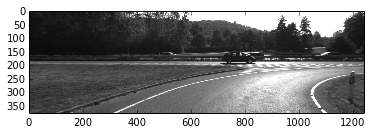

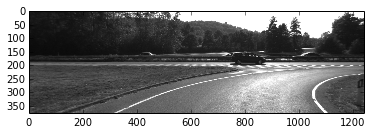

In [3]:
img.read_image()
img.copy_image()
img.acquire()
%matplotlib inline
plt.imshow(img.prev_image)
plt.show()
plt.imshow(img.new_image)
plt.show()

Now, we must seek features in both images that we can correlate and then extract the relative pose of the second image from the former. The correlate_image on utils split the image in regions of interest and find in each region the features. This is useful as we don't want that the features are concentrated in a particular area.

Once the features are founded, the function correlate them:

In [4]:
p1, p2 = utils.correlate_image(matcher, img, 2, 7)

The list of keypoints is emtpy
The list of keypoints is NOT empty
 Matching...
True
matches after distance 14
Matches1 after distance filter:                    14
matches after distance 34
Matches2 after distance filter:                     34
Ended distance filtering
True
Go to filter asymmetric matches...
matches after simmetric filter 5
The list of keypoints is NOT empty
 Matching...
True
matches after distance 248
Matches1 after distance filter:                    248
matches after distance 188
Matches2 after distance filter:                     188
Ended distance filtering
True
Go to filter asymmetric matches...
matches after simmetric filter 44
The list of keypoints is NOT empty
 Matching...
True
matches after distance 422
Matches1 after distance filter:                    422
matches after distance 288
Matches2 after distance filter:                     288
Ended distance filtering
True
Go to filter asymmetric matches...
matches after simmetric filter 83
The list of keypoints i

The Matcher class filter the keypoints by a simmetry and a distance test, removing those keypoints that doesn't have good quality. Let's see how many keypoints we have found in both images:

In [5]:
print ("Total number of good keypoints: \
        {}".format(len(matcher.global_kpts1)))


Total number of good keypoints:         770


Let's see those keypoints on the current image:

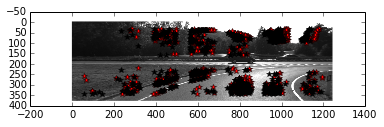

In [6]:
utils.plot_matches(matcher, img)

The keypoints belonging to the previous image are marked in red, and those belonging to the current image are marked in black. As we can see, the later ones have moved to the left, which means that the car have moved to the right.

So far we have correlated both images, so we have established the relation {$\boldsymbol{\vec{x}}_i \ \leftrightarrow \ \boldsymbol{\vec{x}}_i'$}. Now, it's time to get the Fundamental matrix $F$ and the structure of the scene. The VisualOdometry class has a method that allows to compute F from the correspondences {$\boldsymbol{\vec{x}}_i \ \leftrightarrow \ \boldsymbol{\vec{x}}_i'$}, the *EstimateF_multiprocessing* method. This function compute the Fundamental matrix in a parallel process so, if wanted, the main process could do other staff. The method calls uses a *Queue* object to pass the data to the new process, and call the *FindFundamentalRansacPro* method, which in turn calls the findFundamentalMat function of OpenCV. 

The arguments of the method are the keypoints founded in the images, the previous and the current one. It returns the **inliers** as estimated by the Ransac algorithm, and store the computed fundamental matrix in the F attribute of the VisualOdometry class.

In [11]:
matcher.global_kpts1, matcher.global_kpts2 = \
vo.EstimateF_multiprocessing(matcher.global_kpts1, matcher.global_kpts2)

Now, we can see how many keypoints are inliers, as returned by the method and plot them as we have made before:

Inliers: 555


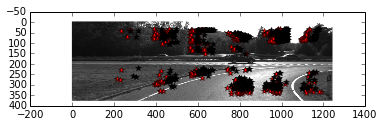

In [16]:
print ("Inliers: {}".format(len(matcher.global_kpts1)))
utils.plot_matches(matcher, img)

We can see that we have less points to represent than before appling the Ransac algorithm. The computed fundamental matrix is:

$$F = \left( \begin{array}{ccc}
-4.65016497e-07 & 1.92473857e-04 & -3.27875941e-02 \\
-1.91744735e-04 & -2.83772416e-06 & 1.08985034e-01 \\
3.30742128e-02 & -1.14811324e-01 & 1.00000000e+00 \end{array} \right)$$

Check that $F$ is singular:

In [17]:
print ("det F = {}".format(np.linalg.det(vo.F)))

det F = 6.44310674393e-21


We can see that the determinant of $F$ is basically zero. Now that we have an initial estimate of the Fundamental matrix we can get the structure of the scene, up to a projectivity:

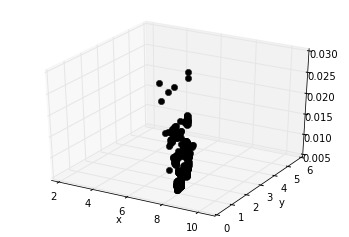

In [19]:
scene = utils.get_structure(matcher, img, vo)
utils.plot_scene(scene)

Also, we can compute the reprojection error:

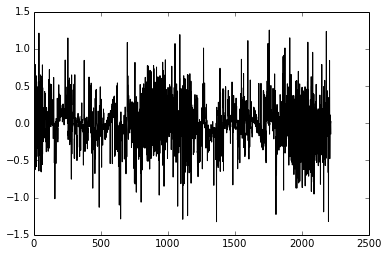

In [29]:
vec = None
vec = np.hstack(vo.cam2.P)
vec2 = np.delete(vo.structure, 3, 0)
vec2 = vec2.reshape(-1)
vec = np.append(vec, vec2)
prior_error = vo.functiontominimize(vec, matcher.global_kpts1, 
                                    matcher.global_kpts2)
plt.plot(prior_error, 'k')